In [1]:
from IPython.display import display
from IPython.display import Image
import os
from utils import * # Code shared across more than one notebook


In [2]:
output_path = "6-output_data/"

if not os.path.exists(output_path):
    os.mkdir(output_path)

**Main contributors:** T. Wen, A. Sujar and F. P. Vidal

**Purpose:** In this notebook, we aim to demonstrate that gVirtualXRay is able to generate analytic simulations on GPU comparable to real images from the [Visible Human Project (VHP)](https://www.nlm.nih.gov/research/visible/visible_human.html). We register the data provided by VoxelMan segmented from the cadaver's CT and cryosections onto a pelvis radiograph of the human participant. All the acquisition parameters are unknown and would need to be estimated.

**Material and Methods:** We use the definitions of tissue substitutes provided in the [ICRU Report 44](https://www.icru.org/report/tissue-substitutes-in-radiation-dosimetry-and-measurement-report-44/) by the [International Commission on Radiation Units and Measurements](https://www.icru.org/). <!--The material composition is available at [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html).-->

![](4-output_data/VHP_model.png)

**Results:** The **[zero-mean normalised cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)) is 59.50%**. 
The **[Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity) is 0.38**. 

![Comparison of a real radiograph of the Visible Human and a corresponding image simulated with gVirtualXray](4-output_data/full_comparison_VHP-NSGA2.png)

The calculations were performed on the following platform:

In [3]:
printSystemInfo()

OS:
	Windows 10
	AMD64

CPU:
 	AMD Ryzen 5 5600X 6-Core Processor

RAM:
	16 GB
GPU:
	Name: NVIDIA GeForce GTX 970
	Drivers: 528.02
	Video memory: 4 GB


# Import packages

In [4]:
%matplotlib inline

import os # Locate files
from time import sleep
from pathlib import Path

import datetime
import math
import numpy as np # Who does not use Numpy?
import pandas as pd # Load/Write CSV files

import matplotlib
# old_backend =  matplotlib.get_backend() 
# matplotlib.use("Agg")  # Prevent showing stuff

from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
import matplotlib.colors as mcolors
import matplotlib.image as mpimg # To save PNG files from numpy arrays

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 22
       }
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

from scipy.stats import pearsonr # Compute the correlatio coefficient
from skimage.util import compare_images # Checkboard comparison between two images

from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_percentage_error as mape
# from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tifffile import imread, imwrite # Load/Write TIFF files

import base64

import urllib, unlzw3 # To download the phantom data, and extract the corresponding Z file

from gvxrPython3 import gvxr # Simulate X-ray images
from gvxrPython3 import json2gvxr # Set gVirtualXRay and the simulation up
from gvxrPython3.utils import visualise
from utils import * # Code shared across more than one notebook

import sys

import cil

from pathlib import Path
import SimpleITK as sitk

xpecgen is not install, you won't be able to load a beam spectrum using xpecgen
SimpleGVXR 2.0.3 (2023-01-13T15:03:56) [Compiler: Microsoft Visual Studio] on Windows
gVirtualXRay core library (gvxr) 2.0.3 (2023-01-13T15:03:54) [Compiler: Microsoft Visual Studio] on Windows


# Reference image

We first load the reference image from the [Visible Human Project](https://www.nlm.nih.gov/databases/download/vhp.html). You can find it at [https://data.lhncbc.nlm.nih.gov/public/Visible-Human/Male-Images/radiological/xray8/x_vm_pe.Z](https://data.lhncbc.nlm.nih.gov/public/Visible-Human/Male-Images/radiological/xray8/x_vm_pe.Z). When you download it, make sure to gunzip it!

In [5]:
if not os.path.exists("VHP"):
    os.mkdir("VHP")

if not os.path.exists("VHP/x_vm_pe.Z"):
    urllib.request.urlretrieve("https://data.lhncbc.nlm.nih.gov/public/Visible-Human/Male-Images/radiological/xray14/x_vm_pe.Z", "VHP/x_vm_pe.Z")
        
if not os.path.exists("VHP/x_vm_pe"):

    file_content = unlzw3.unlzw(Path("VHP/x_vm_pe.Z"))
    f = open('VHP/x_vm_pe', 'wb')
    f.write(file_content)
    f.close()    

In [6]:
#first_slice = 1012
#last_slice = 2893
first_slice = 1006
last_slice = 2882
if not os.path.exists("VHP/CT"):
    os.mkdir("VHP/CT")

if not os.path.exists("VHP/Headers"):
    os.mkdir("VHP/Headers")

URL_path = "https://data.lhncbc.nlm.nih.gov/public/Visible-Human/Male-Images/radiological/frozenCT/"
URL_path_headers = "https://data.lhncbc.nlm.nih.gov/public/Visible-Human/Male-Images/radiological/frozenCTHeaders/"
urllib.request.urlretrieve(URL_path + "README", "VHP/CT/README")

missing_slices = []
reference_CT_volume = []
headers = []

if not os.path.exists("VHP/CT/dataFrozen.mha"):
    for i in range(first_slice, last_slice + 1):
        fname = "c_vm" + str(i) + ".fro"
        fname_zipped = fname + ".Z"

        fname_header = "c_vm" + str(i) + ".fro.txt"
        if not os.path.exists("VHP/Headers/" + fname_header):
            try:
                urllib.request.urlretrieve(URL_path_headers + fname_header, "VHP/Headers/" + fname_header)
            except:
                c = 0;
                #print("Could not retrieve headers for slice #", i);

        else: 
            with open("VHP/Headers/" + fname_header) as file:
                headers.append(file.readlines())

        if not os.path.exists("VHP/CT/" + fname):

            try:
                urllib.request.urlretrieve(URL_path + fname_zipped, "VHP/CT/" +fname_zipped)

                #uncompressed_data = unlzw.unlzw(Path("VHP/CT/" + fname_zipped))
                uncompressed_data = unlzw3.unlzw(Path("VHP/CT/" + fname_zipped).read_bytes())

                f = open("VHP/CT/" + fname, 'wb')
                f.write(uncompressed_data)
                f.close()
                
                raw_reference = np.memmap("VHP/CT/" + fname, offset=3416, dtype=np.dtype('>i2'), mode='r')            
                raw_reference.shape = (512, 512)
                

            except:
                missing_slices.append(i)
                print("Slice", i, "is missing.") 
                raw_reference = -1024 * np.ones((512, 512), dtype=np.int16)
                
        else:
            
            

            try:
            
                raw_reference = np.memmap("VHP/CT/" + fname, offset=3416, dtype=np.dtype('>i2'), mode='r')            
                raw_reference.shape = (512, 512)
            
            except:
                print("Slice", i, "is not well formatted.") 
                
                raw_reference = -1024 * np.ones((512, 512), dtype=np.int16)

        reference_CT_volume.append(raw_reference)

   

    image = sitk.GetImageFromArray(reference_CT_volume)
    # image.SetOrigin((0, 0, 0))
    # image.SetSpacing(spacing)

    writer = sitk.ImageFileWriter()
    writer.SetFileName("VHP/CT/dataFrozen.mha")
    writer.Execute(image)
else:
    print("Reading previously generated vhp CT")
    sitk_reader = sitk.ImageFileReader();
    sitk_reader.SetImageIO("MetaImageIO");
    sitk_reader.SetFileName("VHP/CT/dataFrozen.mha")
    image = sitk_reader.Execute()    
    reference_CT_volume = sitk.GetArrayFromImage(image);


slice_start = 248
slice_end = slice_start + 774;

reference_CT_volume = reference_CT_volume[slice_start:slice_end, :, :]
image = sitk.GetImageFromArray(reference_CT_volume)
writer = sitk.ImageFileWriter()
writer.SetFileName("VHP/CT/dataFrozenReduced.mha")
writer.Execute(image)
# np.memmap('test.bin', dtype=np.dtype('>u2'), mode='r')            
# raw_reference = np.fromfile("VHP/x_vm_pe", dtype='>H') # UINT16 in big endian
# raw_reference.shape = (1536,1248)
# raw_reference = np.rot90(raw_reference)

# # Crop
# y_max = 1000
# raw_reference = raw_reference[:y_max]

Reading previously generated vhp CT


In [7]:

kvp = 120
exposure = 170 #mAs
pixel_spacing = [0.527344, 0.527344]#mm
distance_source_to_detector = 1099.31 #mm
distance_source_to_patient = 630#mm
size = image.GetSize();
slice_thickness = 1.0;#mm
rows = size[2];
columns = size[0]
magnification = distance_source_to_detector / distance_source_to_patient;

print("Magnification:", magnification)
print("kVp:", kvp)
##print("Exposure time (in msec):", exposure_time)
#print("X-ray Tube Current (in mA):", xray_tube_current)
print("Exposure (in mAs):", exposure)
print("Distance Source to Detector (in mm):", distance_source_to_detector)
print("Distance Source to Patient (in mm):", distance_source_to_patient)
print("Pixel Spacing (in mm): ", pixel_spacing)
print("Slice Thickness (in mm): ", slice_thickness)
print("Image size (in px): ", str(columns) + "x" + str(rows))


Magnification: 1.7449365079365078
kVp: 120
Exposure (in mAs): 170
Distance Source to Detector (in mm): 1099.31
Distance Source to Patient (in mm): 630
Pixel Spacing (in mm):  [0.527344, 0.527344]
Slice Thickness (in mm):  1.0
Image size (in px):  512x774


In [8]:
JSON_fname = "notebook-VHP-CT.json"
file_abs_path = os.path.abspath(JSON_fname)
dir_path = os.path.dirname(file_abs_path)

In [9]:
json2gvxr.initGVXR(JSON_fname, "OPENGL")
json2gvxr.initSamples(verbose=0)

Create an OpenGL context: 800x450


In [10]:
#Comparing skin bboxes shows scale difference


scale = 764.98 / 267.74
#scale = round(scale, 0)
# 329.99 / 115.49
# scale = 3.3;
print(scale)
for anatomy in json2gvxr.params["Samples"]:
    label = anatomy["Label"]
    gvxr.scaleNode(label, scale, scale,scale)
    gvxr.applyCurrentLocalTransformation(label)

2.8571748711436467


In [11]:


skin_bbox = gvxr.getNodeOnlyBoundingBox("skin", "mm")
print(skin_bbox)
h = skin_bbox[4] - skin_bbox[1];
h_adj = h * pixel_spacing[0]
print(h)
print(h_adj)

c = [(skin_bbox[0] + skin_bbox[3]) / 2, (skin_bbox[1] + skin_bbox[4]) / 2, (skin_bbox[2] + skin_bbox[5]) / 2]

json2gvxr.params["Detector"]["Position"] = [c[0], 
                                            c[1], #distance_source_to_patient - distance_source_to_detector), 
                                            distance_source_to_patient - distance_source_to_detector, 
                                            "mm"]
json2gvxr.params["Detector"]["UpVector"] =  [-1, 0, 0]


json2gvxr.params["Detector"]["NumberOfPixels"] = [rows, columns]
json2gvxr.params["Detector"]["Spacing"] = [1,1, "mm"]

json2gvxr.initDetector()



json2gvxr.params["Source"]["Position"] = [c[0], 
                                           c[1],# (distance_source_to_detector + skin_bbox[1] + distance_source_to_patient - distance_source_to_detector), 
                                          distance_source_to_patient, 
                                          "mm"]
json2gvxr.params["Source"]["Shape"] = "Parallel"

json2gvxr.initSourceGeometry()

json2gvxr.params["Source"]["Beam"] = {}
json2gvxr.params["Source"]["Beam"]["kvp"] = kvp
json2gvxr.params["Source"]["Beam"]["tube angle"] = 0.00001
#json2gvxr.params["Source"]["Beam"]["filter"] = [["Al", 2.5]]

# json2gvxr.params["Source"]["Beam"] = [{}]
# json2gvxr.params["Source"]["Beam"][0]["Energy"] = 72
# json2gvxr.params["Source"]["Beam"][0]["Unit"] = "keV"
# json2gvxr.params["Source"]["Beam"][0]["PhotonCount"] = 1.0
    
spectrum =json2gvxr.initSpectrum(verbose=0);

(-293.5673828125, -418.95050048828125, -148.21888732910156, 277.4258117675781, 346.0476989746094, 181.76632690429688)
764.9981994628906
403.41721049755864
Set up the detector
	Detector position: [-8.070785522460938, -36.45140075683594, -469.30999999999995, 'mm']
	Detector up vector: [-1, 0, 0]
	Number of pixels: [774, 512]
	Detector number of pixels: [774, 512]
	Pixel spacing: [1, 1, 'mm']
Set up the beam
	Source position: [-8.070785522460938, -36.45140075683594, 630, 'mm']
	Source shape: Parallel


In [12]:
json2gvxr.initScan()
xray_image = minusLog(np.array(gvxr.computeXRayImage()))
gvxr.displayScene()


Set up the CT Scan


In [13]:
imwrite(output_path + '/real_projection.tif', xray_image.astype(np.single))

In [14]:
a = 0/0;

ZeroDivisionError: division by zero

In [ ]:
import json
with open("temp.json", "w") as outfile:
    json.dump(json2gvxr.params, outfile, indent = 4)

In [ ]:
fname = output_path + "/visualisation.png"

if os.path.exists(fname):
    display(Image(fname, width=1000))
else:
    plot = visualise(use_log=True)
    plot.display()

Output()

In [15]:
format = 'plastimatch drr --nrm "{iNRMX} {iNRMY} {iNRMZ}" --vup "0 0 1" -r "{iWidth} {iHeight}" -c "{iCX} {iCY}" -z "{iZx} {iZy}" -t raw --sid {sid} --sad {sad} --output Plastimatch_data/{out} {src}';

sParam = format.format(sid=999999,sad=999999,iNRMX=0, iNRMY=1,iNRMZ = 0, iCX = 512, iCY = 774, iZx = 512, iZy = 774, iWidth=512, iHeight=774, src="VHP/CT/dataFrozenReduced.mha", out = "VHP/drr")
print(sParam)
print(os.system(sParam));
format = "Plastimatch_data/{in_name}0000.raw";
drr= readPlastimatchImageAsNumpy(format.format(in_name = "VHP/drr"), 512, 774);
imwrite(output_path + '/test.tif', drr.astype(np.single))

plastimatch drr --nrm "0 1 0" --vup "0 0 1" -r "512 774" -c "512 774" -z "512 774" -t raw --sid 999999 --sad 999999 --output Plastimatch_data/VHP/drr VHP/CT/dataFrozenReduced.mha
0


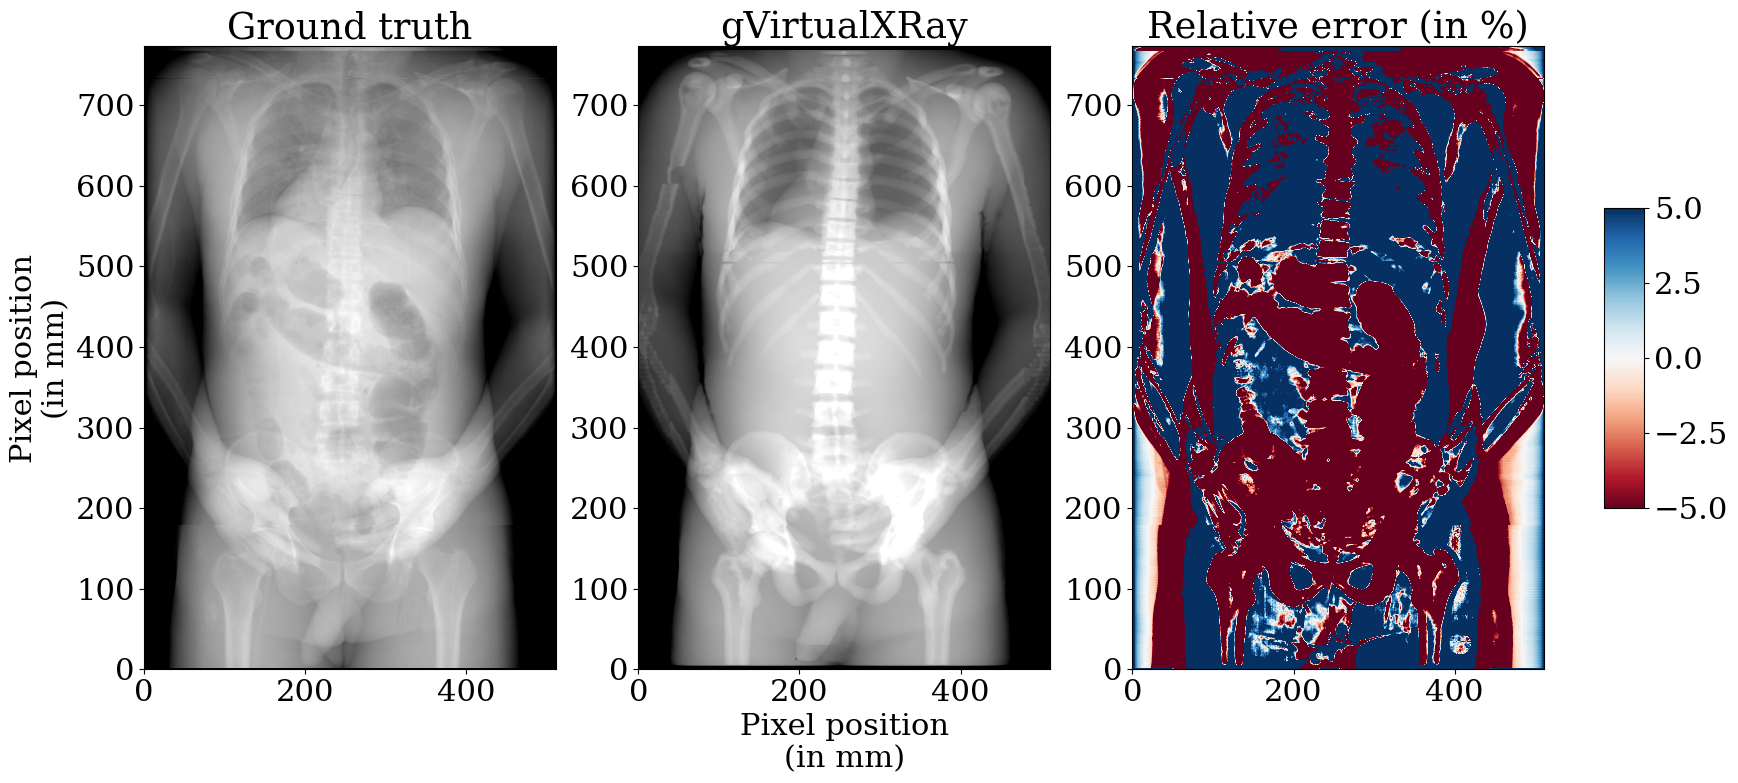

0.89261425


In [16]:
#plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['text.usetex'] = False
drr[drr == 0] = 0.000001;
first_slice_ref = np.flip(np.flip(standardisation(drr)), axis=1);
first_slice_test = np.rot90(standardisation(xray_image))
ZNCC = np.mean((first_slice_ref - first_slice_ref.mean()) / first_slice_ref.std() * (first_slice_test - first_slice_test.mean()) / first_slice_test.std())
fullCompareImages(np.flip(np.flip(standardisation(drr)), axis=1), np.rot90(standardisation(xray_image)),"title", output_path + "test",spacing=[1,1], vmin=-1.5, vmax=1.5)
plt.show()
print(ZNCC)

In [ ]:
# missing_slices = []

# for i in range(first_slice, last_slice + 1):
# fname = "c_vm" + str(i) + ".fre"

# if not os.path.exists("VHP/CT/" + fname):

#     print("Process", URL_path + fname + ".Z")

#     try:


#     except:
#         missing_slices.append(i)
#         print("Slice", i, "is missing.") 

import numpy as np
from utils import displayLinearPowerScales

i = first_slice
fname = "c_vm" + str(i) + ".fre"

raw_reference = np.memmap("VHP/CT/" + fname, offset=3416, dtype=np.dtype('>i2'), mode='r')            
# raw_reference = np.fromfile("VHP/x_vm_pe", dtype='>H') # UINT16 in big endian
raw_reference.shape = (512, 512)



In [ ]:
first_slice = 1012

raw_reference = np.fromfile("VHP/x_vm_pe", dtype='>H') # UINT16 in big endian
raw_reference.shape = (1536,1248)
raw_reference = np.rot90(raw_reference)

# Crop
y_max = 1000
raw_reference = raw_reference[:y_max]

In [ ]:
imwrite(output_path + '/real_projection-VHP.tif', raw_reference.astype(np.single))

In [ ]:
corrected_real_projection = raw_reference.astype(np.single) / raw_reference.max()

In [ ]:
imwrite(output_path + '/corrected_real_projection-VHP.tif', corrected_real_projection.astype(np.single))

We plot the image using a linear look-up table and a power-law normalisation.

In [ ]:
displayLinearPowerScales(corrected_real_projection,
                         "Reference image from the Visible Human Project (male)",
                         output_path + "/reference-VHP",
                         log=True)

Apply a log transformation

In [ ]:
ground_truth = raw_reference
log_ground_truth = np.log(corrected_real_projection)
normalised_log_ground_truth = standardisation(log_ground_truth)

# imwrite(output_path + '/ground_truth-VHP.tif', ground_truth.astype(np.single))

# Setting up gVirtualXRay

Before simulating an X-ray image using gVirtualXRay, we must create an OpenGL context.

In [ ]:
json2gvxr.initGVXR("notebook-6.json", "EGL")

## X-ray source

We create an X-ray source. It is a point source.

In [ ]:
json2gvxr.initSourceGeometry()

## Spectrum

The spectrum is polychromatic.

In [ ]:
spectrum, unit, k, f = json2gvxr.initSpectrum(verbose=0)
energy_set = sorted(spectrum.keys())

count_set = []

for energy in energy_set:
    count_set.append(spectrum[energy])

Plot the spectrum

In [ ]:
plotSpectrum(k, f, output_path + '/spectrum-VHP')

## Detector

Create a digital detector

In [ ]:
json2gvxr.initDetector()

## Sample

We now load the models segmented from the Visible Human.

Load the samples. `verbose=2` is used to print the material database for Gate. To disable it, use `verbose=0` or `verbose=1`.

In [ ]:
json2gvxr.initSamples(verbose=0)

In [ ]:
number_of_triangles = 0

for sample in json2gvxr.params["Samples"]:
    label = sample["Label"]
    number_of_triangles_in_mesh = gvxr.getNumberOfPrimitives(label)
    number_of_triangles += number_of_triangles_in_mesh
    
    print(label, \
          "has", \
          f"{number_of_triangles_in_mesh:,}", \
          "triangles.")

print("\nThere are", f"{number_of_triangles:,}", "triangles in total")

Apply the scaling factor from voxels to cm.

In [ ]:
for anatomy in json2gvxr.params["Samples"]:
    label = anatomy["Label"]
    gvxr.scaleNode(label, 3.3, 3.3, 3.3)
    gvxr.applyCurrentLocalTransformation(label)

## Simulation with the default values

In [ ]:
# Backup the transformation matrix
global_matrix_backup = gvxr.getSceneTransformationMatrix()

In [ ]:
def getXRayImage():
    global total_energy_in_MeV

    # Compute the X-ray image
    xray_image = np.array(gvxr.computeXRayImage())
    
    # Apply the ROI
    xray_image = xray_image[:y_max]
    
    # Flat-field
#     xray_image /= total_energy_in_MeV
    
    # Negative
    # x_ray_image = 1.0 - x_ray_image
    return xray_image #np.ones(xray_image.shape).astype(np.single) - xray_image

In [ ]:
xray_image = getXRayImage()

In [ ]:
# gvxr.enableArtefactFilteringOnCPU()
gvxr.enableArtefactFilteringOnGPU()
# gvxr.disableArtefactFiltering() # Spere inserts are missing with GPU integration when a outer surface is used for the matrix

In [ ]:
# total_energy_in_keV = 0.0
# for energy, count in zip(energy_set, count_set):
#     effective_energy = find_nearest(detector_response[:,0], energy / 1000, detector_response[:,1])

#     total_energy_in_keV += effective_energy * count
    
total_energy_in_MeV = gvxr.getTotalEnergyWithDetectorResponse()

In [ ]:
xray_image = getXRayImage()

In [ ]:
gvxr.displayScene()
gvxr.useNegative()

gvxr.setZoom(1569.6787109375)
gvxr.setSceneRotationMatrix([-0.3190782964229584,  -0.15100032091140747, -0.9356207251548767,  0.0,
                              0.002036974299699068, 0.987101674079895,   -0.16000667214393616, 0.0,
                              0.9477221369743347,  -0.05296054854989052, -0.31466084718704224, 0.0, 
                              0.0,                  0.0,                  0.0,                 1.0])

gvxr.setWindowBackGroundColour(0.5, 0.5, 0.5)

gvxr.displayScene()

In [ ]:
# gvxr.renderLoop()

In [ ]:
# print(gvxr.getZoom())
# print(gvxr.getSceneRotationMatrix())

In [ ]:
screenshot = (255 * np.array(gvxr.takeScreenshot())).astype(np.uint8)

In [ ]:
fname = 'VHP/default-screenshot.png'
if True:#not os.path.isfile(fname):

    plt.imsave(fname, screenshot)

In [ ]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig(output_path + '/default-screenshot-beam-on-VHP.pdf')
plt.savefig(output_path + '/default-screenshot-beam-on-VHP.png', bbox_inches = 'tight')

In [ ]:
def logImage(xray_image: np.array, min_val: float, max_val: float) -> np.array:
    
    log_epsilon = 1.0e-9

    shift_filter = -math.log(min_val + log_epsilon)
    
    if min_val != max_val:
        scale_filter = 1.0 / (math.log(max_val + log_epsilon) - math.log(min_val + log_epsilon))
    else:
        scale_filter = 1.0

    corrected_image = np.log(xray_image + log_epsilon)

    return (corrected_image + shift_filter) * scale_filter

In [ ]:
displayLinearPowerScales(1 - logImage(xray_image, xray_image.min(), xray_image.max()),
                         "Image simulated using gVirtualXRay before the registration",
                         output_path + "/gVirtualXRay-before_registration-VHP",
                         log=False)

# Registration

## Single-objective optimisation with CMA-ES

1st using CMA-ES with 5 different fitness functions, then using NSGA2 and NSGA3.

In [ ]:
roi_ground_truth_min = ground_truth.min()
roi_ground_truth_max = ground_truth.max()
standardised_roi_ground_truth = standardisation(ground_truth)

imsave(output_path + '/standardised_roi_ground_truth-VHP.tif', standardised_roi_ground_truth.astype(np.single))

In [ ]:
source_position = gvxr.getSourcePosition("cm")
detector_position = gvxr.getDetectorPosition("cm")

x_init = [
    # Orientation of the sample
    0.0, 0.0,

    # Position of the source
    source_position[0],
    source_position[1],
    source_position[2],

    # Position of the detector
    detector_position[0],
    detector_position[1],
    detector_position[2]#,

    # Orientation of the detector
    #     det_rotation_angle1 = x[8]
    #     det_rotation_angle2 = x[9]

#         1.0 / 3.0, # c1
#         1.0, # gain1
#         0.0, # bias1

#         1.0 / 3.0, # c2
#         1.0, # gain2
#         0.0#, # bias2

#         1.0 / 3.0, # c3
#         1.0, # gain3
#         0.0, # bias3
#         2.0 # gamma
]

In [ ]:
pos_offset = 20
angle_offset = 15

xl = [
            -angle_offset, -angle_offset, 
            source_position[0] - pos_offset, source_position[1] - pos_offset, source_position[2] - pos_offset,
            detector_position[0] - pos_offset, detector_position[1] - pos_offset, detector_position[2] - pos_offset#,
#             -90, -90, 
#             -10.0,
#             -10.0,
#             -10.0,

#             -10.0,
#             0.0,
#             0.0#,

#             -10.0,
#             -10.0,
#             -10.0,
#             0.0
        ]

xu = [
            angle_offset, angle_offset, 
            source_position[0] + pos_offset, source_position[1] + pos_offset, source_position[2] + pos_offset,
            detector_position[0] + pos_offset, detector_position[1] + pos_offset, detector_position[2] + pos_offset #,
#             90, 90, 
#             10.0,
#             10.0,
#             10.0,

#             10.0,
#             10.0,
#             10.0#,

#             10.0,
#             10.0,
#             10.0,
#             100.0
        ]

In [ ]:
def setTransformations(x):
    # Orientation of the sample
    sample_rotation_angle1 = x[0]
    sample_rotation_angle2 = x[1]

    gvxr.rotateScene(sample_rotation_angle1, 1, 0, 0)
    gvxr.rotateScene(sample_rotation_angle2, 0, 1, 0)

    # Position of the source
    source_position_x = x[2]
    source_position_y = x[3]
    source_position_z = x[4]
    
    gvxr.setSourcePosition(
        source_position_x,
        source_position_y,
        source_position_z,
        "cm"
    )
    
    # Position of the detector
    det_position_x = x[5]
    det_position_y = x[6]
    det_position_z = x[7]
    
    gvxr.setDetectorPosition(
        det_position_x,
        det_position_y,
        det_position_z,
        "cm"
    )

    # Orientation of the detector
#     det_rotation_angle1 = x[8]
#     det_rotation_angle2 = x[9]    

In [ ]:
def resetToDefaultParameters():
    json2gvxr.initDetector("notebook-4.json")
    json2gvxr.initSourceGeometry("notebook-4.json")
    source_position = gvxr.getSourcePosition("cm")
    detector_position = gvxr.getDetectorPosition("cm")

    # Restore the transformation matrix
    gvxr.setSceneTransformationMatrix(global_matrix_backup)

In [ ]:
def updateXRayImage(x):
    
    
    # Backup the transformation matrix
    matrix_backup = gvxr.getSceneTransformationMatrix()

    # Set the transformations
    setTransformations(x)

    # Compute the X-ray image
    xray_image = getXRayImage()

#     gvxr.displayScene()
#     screenshot = gvxr.takeScreenshot()

    # Restore the transformation matrix
    gvxr.setSceneTransformationMatrix(matrix_backup)

    return xray_image #, screenshot

In [ ]:
def applyLogScaleAndNegative(image: np.array) -> np.array:
    temp = logImage(image, image.min(), image.max())
    return 1.0 - temp

In [ ]:
timeout_in_sec = 20 * 60 # 20 minutes

## Define an objective function

In [ ]:
def objectiveFunction(x):
    
    global objective_function_string
    
    global ground_truth, standardised_roi_ground_truth
    global best_fitness, best_fitness_id, fitness_function_call_id, evolution_fitness, evolution_parameters


    xray_image = updateXRayImage(x)
    corrected_xray_image = applyLogScaleAndNegative(xray_image)
    standardised_corrected_xray_image = standardisation(corrected_xray_image)
    
    if objective_function_string == "zncc":
        zncc = np.mean(standardised_roi_ground_truth * standardised_corrected_xray_image)
        dzncc = (1.0 - zncc) / 2.0
        objective = dzncc
    elif objective_function_string == "mae":
        mae = np.mean(np.abs(standardised_roi_ground_truth - standardised_corrected_xray_image))
        objective = mae
    elif objective_function_string == "rmse":
        rmse = math.sqrt(np.mean(np.square(standardised_roi_ground_truth - standardised_corrected_xray_image)))
        objective = rmse
    elif objective_function_string == "ssim":        
        ssim_value = ssim(standardised_roi_ground_truth, standardised_corrected_xray_image, data_range=standardised_roi_ground_truth.max() - standardised_roi_ground_truth.min())
        dssim = (1.0 - ssim_value) / 2.0
        objective = dssim
    elif objective_function_string == "mape":
        # Avoid div by 0
        offset1 = min(standardised_roi_ground_truth.min(), standardised_corrected_xray_image.min())
        offset2 = 0.01 * (standardised_roi_ground_truth.max() - standardised_roi_ground_truth.min())
        offset = offset2 - offset1
        mape_value = mape(standardised_roi_ground_truth + offset, standardised_corrected_xray_image + offset)
        objective = mape_value

    if best_fitness > objective:
            
        evolution_fitness.append([fitness_function_call_id, objective])
        
        row = [fitness_function_call_id]
        for i in x:
            row.append(i)
        evolution_parameters.append(row)
        
        best_fitness = objective
    
    fitness_function_call_id += 1
    
    return objective

In [ ]:
def optimiseWithCMAES(objective_function_str: str):

    global objective_function_string
    global best_fitness
    global best_fitness_id
    global fitness_function_call_id
    global evolution_fitness
    global evolution_parameters
    
    resetToDefaultParameters()

    objective_function_string = objective_function_str
    
    source_position = [0.0, 0.0, 0.0]
    detector_position = [0.0, 0.0, 0.0]


    if os.path.exists(output_path + "/HIPS-" + objective_function_string + ".dat") and \
        os.path.exists(output_path + "/HIPS_evolution-" + objective_function_string + ".dat") and \
        os.path.exists(output_path + "/HIPS_evolution_parameters-" + objective_function_string + ".dat"):
        
        temp = np.loadtxt(output_path + "/HIPS-" + objective_function_string + ".dat")
        
        sample_rotation_angle1 = temp[0]
        sample_rotation_angle2 = temp[1]
        source_position[0] = temp[2]
        source_position[1] = temp[3]
        source_position[2] = temp[4]
        detector_position[0] = temp[5]
        detector_position[1] = temp[6]
        detector_position[2] = temp[7]

        evolution_fitness = np.loadtxt(output_path + "/HIPS_evolution-" + objective_function_string + ".dat")
        evolution_parameters = np.loadtxt(output_path + "/HIPS_evolution_parameters-" + objective_function_string + ".dat")

    # CMA-ES
    else:

        opts = cma.CMAOptions()
        opts.set('tolfun', 1e-5)
        opts['tolx'] = 1e-5
        opts['timeout'] = timeout_in_sec
        opts['bounds'] = [xl, xu]

        opts['CMA_stds'] = []

        for min_val, max_val in zip(opts['bounds'][0], opts['bounds'][1]):
            opts['CMA_stds'].append(abs(max_val - min_val) * 0.5)

        best_fitness = sys.float_info.max
        best_fitness_id = 0
        fitness_function_call_id = 0
        evolution_fitness = []
        evolution_parameters = []

        res = cma.fmin(objectiveFunction,
                  x_init,
                  0.5,
                  opts,
                  restarts=0)

        # Save the best individual
        sample_rotation_angle1 = res[0][0]
        sample_rotation_angle2 = res[0][1]
        source_position[0] = res[0][2]
        source_position[1] = res[0][3]
        source_position[2] = res[0][4]
        detector_position[0] = res[0][5]
        detector_position[1] = res[0][6]
        detector_position[2] = res[0][7]

        # Save best parameters from the optimiser
        answer = np.array([sample_rotation_angle1, sample_rotation_angle2, source_position[0], source_position[1], source_position[2], detector_position[0], detector_position[1], detector_position[2]])
        answer = answer.reshape(1, answer.shape[0])
        np.savetxt(output_path + "/HIPS-" + objective_function_string + ".dat",
                   answer,
                   header='sample_rotation_angle1, sample_rotation_angle2,source_pos_x,source_pos_y,source_pos_z,detector_pos_x,detector_pos_y,detector_pos_z')

        # Save the list of zncc for plotting
        evolution_fitness = np.array(evolution_fitness)
        np.savetxt(output_path + "/HIPS_evolution-" + objective_function_string + ".dat",
                   evolution_fitness,
                   header='t,' + objective_function_string)

        # Save the list of parameters for plotting
        evolution_parameters = np.array(evolution_parameters)
        print(evolution_parameters.shape)
        
        np.savetxt(output_path + "/HIPS_evolution_parameters-" + objective_function_string + ".dat",
                   evolution_parameters, 
                   header='t,sample_rotation_angle1,sample_rotation_angle2,source_pos_x,source_pos_y,source_pos_z,detector_pos_x,detector_pos_y,det_position_z')
    
    return [sample_rotation_angle1, sample_rotation_angle2, source_position[0], source_position[1], source_position[2], detector_position[0], detector_position[1], detector_position[2]], \
        evolution_fitness, \
        evolution_parameters

## Run the optimisation for each image comparison method

In [ ]:
objective_function_string = "zncc"
x_zncc, evolution_fitness_zncc, evolution_parameters_zncc = optimiseWithCMAES("zncc")

resetToDefaultParameters()
xray_image_zncc = applyLogScaleAndNegative(updateXRayImage(x_zncc))

In [ ]:
objective_function_string = "mae"
x_mae, evolution_fitness_mae, evolution_parameters_mae = optimiseWithCMAES("mae")

resetToDefaultParameters()
xray_image_mae = applyLogScaleAndNegative(updateXRayImage(x_mae))

In [ ]:
objective_function_string = "rmse"
x_rmse, evolution_fitness_rmse, evolution_parameters_rmse = optimiseWithCMAES("rmse")

resetToDefaultParameters()
xray_image_rmse = applyLogScaleAndNegative(updateXRayImage(x_rmse))

In [ ]:
objective_function_string = "ssim"
x_ssim, evolution_fitness_ssim, evolution_parameters_ssim = optimiseWithCMAES("ssim")

resetToDefaultParameters()
xray_image_ssim = applyLogScaleAndNegative(updateXRayImage(x_ssim))

In [ ]:
objective_function_string = "mape"
x_mape, evolution_fitness_mape, evolution_parameters_mape = optimiseWithCMAES("mape")

resetToDefaultParameters()
xray_image_mape = applyLogScaleAndNegative(updateXRayImage(x_mape))

In [ ]:
fig = make_subplots(rows=1, cols=5, start_cell="bottom-left",
                    subplot_titles=("Evolution of DZNCC", "Evolution of DSSIM", "Evolution of MAE", "Evolution of RMSE", "Evolution of MAPE"))

# fig.add_trace(go.Scatter(x=evolution_fitness_zncc[:,0], y=1.0 - (2.0 * evolution_fitness_zncc[:,1])),
fig.add_trace(go.Scatter(x=evolution_fitness_zncc[:,0], y=evolution_fitness_zncc[:,1]),
              row=1, col=1)

# fig.add_trace(go.Scatter(x=evolution_fitness_ssim[:,0], y=1.0 - (2.0 * evolution_fitness_ssim[:,1])),
fig.add_trace(go.Scatter(x=evolution_fitness_ssim[:,0], y=evolution_fitness_ssim[:,1]),
              row=1, col=2)

fig.add_trace(go.Scatter(x=evolution_fitness_mae[:,0], y=evolution_fitness_mae[:,1]),
              row=1, col=3)

fig.add_trace(go.Scatter(x=evolution_fitness_rmse[:,0], y=evolution_fitness_rmse[:,1]),
              row=1, col=4)

fig.add_trace(go.Scatter(x=evolution_fitness_mape[:,0], y=evolution_fitness_mape[:,1]),
              row=1, col=5)

# Update xaxis properties
fig.update_xaxes(title_text="Timeline", row=1, col=1)
fig.update_xaxes(title_text="Timeline", row=1, col=2)
fig.update_xaxes(title_text="Timeline", row=1, col=3)
fig.update_xaxes(title_text="Timeline", row=1, col=4)
fig.update_xaxes(title_text="Timeline", row=1, col=5)

# Update yaxis properties
# fig.update_yaxes(title_text="Ojective function: ZNCC", row=1, col=1)
# fig.update_yaxes(title_text="Ojective function: MAE", row=1, col=2)
# fig.update_yaxes(title_text="Ojective function: RMSE", row=1, col=3)
# fig.update_yaxes(title_text="Ojective function: SSIM", row=1, col=4)
# fig.update_yaxes(title_text="Ojective function: MAPE", row=1, col=5)

# fig.update_yaxes(title_text="yaxis 2 title", range=[40, 80], row=1, col=2)
# fig.update_yaxes(title_text="yaxis 3 title", showgrid=False, row=2, col=1)
# fig.update_yaxes(title_text="yaxis 4 title", row=2, col=2)

fig.update_layout(showlegend=False)

fig.update_layout(
    font_family="Arial",
    font_color="black",
    title_font_family="Arial",
    title_font_color="black",
    legend_title_font_color="black"
)

fig.update_layout(
    height=500,
    width=1000
)

fig.write_image(output_path + "/HIPS_evolution-objectives.pdf", engine="kaleido")
fig.write_image(output_path + "/HIPS_evolution-objectives.png", engine="kaleido")

fig.show()

In [ ]:
fig = make_subplots(rows=1, cols=6,
                    start_cell="bottom-left",
                    subplot_titles=("Ground truth", "Best DZNCC", "Best DSSIM", "Best MAE", "Best RMSE", "Best MAPE"))

cmaes_img_set = [standardised_roi_ground_truth,
                 standardisation(xray_image_zncc),
                 standardisation(xray_image_ssim), 
                 standardisation(xray_image_mae), 
                 standardisation(xray_image_rmse), 
                 standardisation(xray_image_mape)]

for n, image in enumerate(cmaes_img_set):
    
    im = px.imshow(image, aspect="equal", binary_string=True, zmin=standardised_roi_ground_truth.min(), zmax=standardised_roi_ground_truth.max())
    fig.add_trace(im.data[0], 1, n + 1)

fig.update_xaxes(showticklabels=False) # hide all the xticks
fig.update_yaxes(showticklabels=False) # hide all the yticks
fig.update_layout(coloraxis_showscale=False)

fig.update_layout(
    font_family="Arial",
    font_color="black",
    title_font_family="Arial",
    title_font_color="black",
    legend_title_font_color="black"
)

fig.update_layout(
    height=300,
    width=1200
)

fig.write_image(output_path + "/HIPS_cmaes-objectives.pdf", engine="kaleido")
fig.write_image(output_path + "/HIPS_cmaes-objectives.png", engine="kaleido")

fig.show()

In [ ]:
cmaes_x_set   =  [x_zncc, x_mae, x_rmse, x_ssim, x_mape]
cmaes_img_set = [xray_image_zncc, xray_image_mae, xray_image_rmse, xray_image_ssim, xray_image_mape]

temp_res_cmaes = []

for n, [x, image] in enumerate(zip(cmaes_x_set, cmaes_img_set)):
    
    row = copy.deepcopy(x)
    
    xray_image = updateXRayImage(x)
    corrected_xray_image = applyLogScaleAndNegative(xray_image)
    standardised_corrected_xray_image = standardisation(corrected_xray_image)
    
    zncc = np.mean(standardised_roi_ground_truth * standardised_corrected_xray_image)
    row.append((1.0 - zncc) / 2.0)
    
    mae = np.mean(np.abs(standardised_roi_ground_truth - standardised_corrected_xray_image))
    row.append(mae)
    
    rmse = math.sqrt(np.mean(np.square(standardised_roi_ground_truth - standardised_corrected_xray_image)))
    row.append(rmse)
    
    ssim_value = ssim(standardised_roi_ground_truth, standardised_corrected_xray_image, data_range=standardised_roi_ground_truth.max() - standardised_roi_ground_truth.min())
    row.append((1.0 - ssim_value) / 2.0)

    # Avoid div by 0
    offset1 = min(standardised_roi_ground_truth.min(), standardised_corrected_xray_image.min())
    offset2 = 0.01 * (standardised_roi_ground_truth.max() - standardised_roi_ground_truth.min())
    offset = offset2 - offset1
    mape_value = mape(standardised_roi_ground_truth + offset, standardised_corrected_xray_image + offset)
    row.append(mape_value)
        
    temp_res_cmaes.append(row)

In [ ]:
df_cmaes = pd.DataFrame(data=temp_res_cmaes,
                  columns=["sample_rotation_angle1", "sample_rotation_angle2", "src_pos_x", "src_pos_y", "src_pos_z", "det_pos_x", "det_pos_y", "det_pos_z", "DZNCC", "MAE", "RMSE", "DSSIM", "MAPE"])

df_cmaes["ZNCC"] = 1.0 - (df_cmaes["DZNCC"] * 2.0)
df_cmaes["SSIM"] = 1.0 - (df_cmaes["DSSIM"] * 2.0)

df_cmaes["Optimiser"] = "CMA-ES"
df_cmaes["Optimiser_code"] = 1
df_cmaes.to_csv(output_path + "/hips-optimiser-cmaes.csv")

In [ ]:
display(df_cmaes)

In [ ]:
fig = px.parallel_coordinates(df_cmaes[["DZNCC", "DSSIM", "MAE", "RMSE", "MAPE", "ZNCC", "SSIM"]], color="DZNCC")
fig.show()

fig.write_image(output_path + "/HIPS-cmaes-parallel_coordinates.pdf", engine="kaleido")
fig.write_image(output_path + "/HIPS-cmaes-parallel_coordinates.png", engine="kaleido")

In [ ]:
fig = px.scatter_matrix(df_cmaes[["DZNCC", "DSSIM", "MAE", "RMSE", "MAPE"]])

fig.update_layout(
    height=800,
    width=800
)

fig.show()

fig.write_image(output_path + "/HIPS-cmaes-scatter_matrix.pdf", engine="kaleido")
fig.write_image(output_path + "/HIPS-cmaes-scatter_matrix.png", engine="kaleido")

## Multi-objective optimisation with NSGA-II

In [ ]:
def objectiveFunctions(x):
    
    global objective_function_string
    
    global ground_truth, standardised_roi_ground_truth
    global best_fitness, best_fitness_id, fitness_function_call_id, evolution_fitness, evolution_parameters

    objectives = []
    
    for ind in x:
        xray_image = updateXRayImage(ind)
        corrected_xray_image = applyLogScaleAndNegative(xray_image)
        standardised_corrected_xray_image = standardisation(corrected_xray_image)

        row = []

        zncc = np.mean(standardised_roi_ground_truth * standardised_corrected_xray_image)
        dzncc = (1.0 - zncc) / 2.0
        row.append(dzncc)

        mae = np.mean(np.abs(standardised_roi_ground_truth - standardised_corrected_xray_image))
        row.append(mae)

        rmse = math.sqrt(np.mean(np.square(standardised_roi_ground_truth - standardised_corrected_xray_image)))
        row.append(rmse)

        ssim_value = ssim(standardised_roi_ground_truth, standardised_corrected_xray_image, data_range=standardised_roi_ground_truth.max() - standardised_roi_ground_truth.min())
        dssim = (1.0 - ssim_value) / 2.0
        row.append(dssim)

        # Avoid div by 0
        offset1 = min(standardised_roi_ground_truth.min(), standardised_corrected_xray_image.min())
        offset2 = 0.01 * (standardised_roi_ground_truth.max() - standardised_roi_ground_truth.min())
        offset = offset2 - offset1
        mape_value = mape(standardised_roi_ground_truth + offset, standardised_corrected_xray_image + offset)
        row.append(mape_value)
    
        objectives.append(row)
        
    return objectives

In [ ]:
from pymoo.core.problem import Problem

class MyMultiObjectiveProblem(Problem):

    def __init__(self):
        super().__init__(n_var=len(x_init),
                         n_obj=5,
                         n_constr=0,
                         xl=xl,
                         xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = objectiveFunctions(x)

In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.factory import get_termination
from pymoo.util.termination import collection

resetToDefaultParameters()

problem = MyMultiObjectiveProblem()

pop_size = 210

x_tol_termination = get_termination("x_tol", 1e-5)
f_tol_termination = get_termination("f_tol", 1e-5)
time_termination = get_termination("time", "01:00:00")

termination = collection.TerminationCollection(x_tol_termination, f_tol_termination, time_termination)

if os.path.exists(output_path + "/VHP-res-nsga2-X.dat") and os.path.exists(output_path + "/VHP-res-nsga2-F.dat"):

    res_nsga2_X = np.loadtxt(output_path + "/VHP-res-nsga2-X.dat")
    res_nsga2_F = np.loadtxt(output_path + "/VHP-res-nsga2-F.dat")

else:

    algorithm = NSGA2(
        pop_size=pop_size,
#         n_offsprings=int(pop_size*0.05),
        eliminate_duplicates=True
    )

    res_nsga2 = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   save_history=True,
                   verbose=True)

    res_nsga2_X = res_nsga2.X
    res_nsga2_F = res_nsga2.F

    np.savetxt(output_path + "/VHP-res-nsga2-X.dat", res_nsga2_X)
    np.savetxt(output_path + "/VHP-res-nsga2-F.dat", res_nsga2_F)

In [ ]:
best_dzncc_id = np.argmin(res_nsga2_F[:,0])
best_mae_id = np.argmin(res_nsga2_F[:,1])
best_rmse_id = np.argmin(res_nsga2_F[:,2])
best_dssim_id = np.argmin(res_nsga2_F[:,3])
best_mape_id = np.argmin(res_nsga2_F[:,4])

print("Lowest DZNCC:", res_nsga2_F[:,0].min(), best_dzncc_id, res_nsga2_X[best_dzncc_id])
print("Lowest DSSIM:", res_nsga2_F[:,3].min(), best_dssim_id, res_nsga2_X[best_dssim_id])
print("Lowest MAE:",   res_nsga2_F[:,1].min(), best_mae_id,   res_nsga2_X[best_mae_id])
print("Lowest RMSE:",  res_nsga2_F[:,2].min(), best_rmse_id,  res_nsga2_X[best_rmse_id])
print("Lowest MAPE:",  res_nsga2_F[:,4].min(), best_mape_id,  res_nsga2_X[best_mape_id])

In [ ]:
xray_image_dzncc_nsga2 = applyLogScaleAndNegative(updateXRayImage(res_nsga2_X[best_dzncc_id]))
xray_image_mae_nsga2   = applyLogScaleAndNegative(updateXRayImage(res_nsga2_X[best_mae_id]))
xray_image_rmse_nsga2  = applyLogScaleAndNegative(updateXRayImage(res_nsga2_X[best_rmse_id]))
xray_image_dssim_nsga2 = applyLogScaleAndNegative(updateXRayImage(res_nsga2_X[best_dssim_id]))
xray_image_mape_nsga2  = applyLogScaleAndNegative(updateXRayImage(res_nsga2_X[best_mape_id]))

In [ ]:
fig = make_subplots(rows=1, cols=6,
                    start_cell="bottom-left",
                    subplot_titles=("Ground truth", "Best DZNCC", "Best DSSIM", "Best MAE", "Best RMSE", "Best MAPE"))

nsga2_img_set = [standardised_roi_ground_truth,
                 standardisation(xray_image_dzncc_nsga2),
                 standardisation(xray_image_dssim_nsga2), 
                 standardisation(xray_image_mae_nsga2), 
                 standardisation(xray_image_rmse_nsga2), 
                 standardisation(xray_image_mape_nsga2)]

for n, image in enumerate(nsga2_img_set):
    
    im = px.imshow(image, aspect="equal", binary_string=True, zmin=standardised_roi_ground_truth.min(), zmax=standardised_roi_ground_truth.max())
    fig.add_trace(im.data[0], 1, n + 1)

fig.update_xaxes(showticklabels=False) # hide all the xticks
fig.update_yaxes(showticklabels=False) # hide all the yticks
fig.update_layout(coloraxis_showscale=False)

fig.update_layout(
    font_family="Arial",
    font_color="black",
    title_font_family="Arial",
    title_font_color="black",
    legend_title_font_color="black"
)

fig.update_layout(
    height=300,
    width=1200
)

fig.write_image(output_path + "/HIPS-NSGA2-objectives.pdf", engine="kaleido")
fig.write_image(output_path + "/HIPS-NSGA2-objectives.png", engine="kaleido")

fig.show()

In [ ]:
df_nsga2 = pd.DataFrame(data=np.append(res_nsga2_X, res_nsga2_F, axis=1),
                  columns=["sample_rotation_angle1", "sample_rotation_angle2", "src_pos_x", "src_pos_y", "src_pos_z", "det_pos_x", "det_pos_y", "det_pos_z", "DZNCC", "MAE", "RMSE", "DSSIM", "MAPE"])

df_nsga2["ZNCC"] = 1.0 - (df_nsga2["DZNCC"] * 2.0)
df_nsga2["SSIM"] = 1.0 - (df_nsga2["DSSIM"] * 2.0)

df_nsga2["Optimiser"] = "NSGA-II"
df_nsga2["Optimiser_code"] = 2
df_nsga2.to_csv(output_path + "/hips-optimiser-nsga2.csv")

In [ ]:
display(df_nsga2)

In [ ]:
fig = px.parallel_coordinates(df_nsga2[["DZNCC", "DSSIM", "MAE", "RMSE", "MAPE", "ZNCC", "SSIM"]], color="DZNCC")
fig.show()

fig.write_image(output_path + "/HIPS-NSGA2-parallel_coordinates.pdf", engine="kaleido")
fig.write_image(output_path + "/HIPS-NSGA2-parallel_coordinates.png", engine="kaleido")

In [ ]:
fig = px.scatter_matrix(df_nsga2[["DZNCC", "DSSIM", "MAE", "RMSE", "MAPE"]])

fig.update_layout(
    height=800,
    width=800
)

fig.show()

fig.write_image(output_path + "/HIPS-NSGA2-scatter_matrix.pdf", engine="kaleido")
fig.write_image(output_path + "/HIPS-NSGA2-scatter_matrix.png", engine="kaleido")

In [ ]:
for i, x in enumerate(res_nsga2_X):
    img = applyLogScaleAndNegative(updateXRayImage(x))
    mpimg.imsave(output_path + "/NSGA2/img_" + str(i) + ".png", (255 * (img - img.min()) / (img.max() - img.min())).astype(np.uint8), cmap="gray")

In [ ]:
best_nsga2_id = 109
x = res_nsga2_X[best_nsga2_id]

nsga2_raw_x_ray_image = xray_image_dzncc_nsga2 = applyLogScaleAndNegative(updateXRayImage(x))
nsga2_raw_x_ray_image = np.array(nsga2_raw_x_ray_image)

mpimg.imsave(output_path + "/NSGA2-img_" + str(best_nsga2_id) + ".png", (255 * (nsga2_raw_x_ray_image - nsga2_raw_x_ray_image.min()) / (nsga2_raw_x_ray_image.max() - nsga2_raw_x_ray_image.min())).astype(np.uint8), cmap="gray")

In [ ]:
source_position = gvxr.getSourcePosition("mm")
detector_position = gvxr.getDetectorPosition("mm")

object_bbox = gvxr.getNodeAndChildrenBoundingBox("root", "mm")
object_position = [(object_bbox[0] + object_bbox[3]) / 2,
                   (object_bbox[1] + object_bbox[4]) / 2,
                   (object_bbox[2] + object_bbox[5]) / 2
                  ]

source_imager_distance = distance.euclidean(source_position, detector_position)
source_object_distance = distance.euclidean(source_position, object_position)

detector_size = np.array(gvxr.getDetectorSize("mm"))
number_of_pixels = gvxr.getDetectorNumberOfPixels()

detector_element_spacing = (detector_size / number_of_pixels)
spacing = source_imager_distance * detector_element_spacing / source_object_distance

print("spacing in the object plane (in mm):", spacing)

In [ ]:

matplotlib.rc('text', usetex=False)

font = {'size'   : 12.5
       }
matplotlib.rc('font', **font)

vmin = standardised_roi_ground_truth.min()
vmax = standardised_roi_ground_truth.max()

fullCompareImages(standardised_roi_ground_truth,
                  standardisation(nsga2_raw_x_ray_image),
                  "gVirtualXRay",
                  output_path + "/full_comparison_VHP-NSGA2", spacing, vmin=vmin, vmax=vmax, log=False)

In [ ]:
runtimes = []

resetToDefaultParameters()
setTransformations(res_nsga2_X[best_nsga2_id])

for i in range(25):
    start_time = datetime.datetime.now()

    temp = gvxr.computeXRayImage()
    
    end_time = datetime.datetime.now()
    delta_time = end_time - start_time
    runtimes.append(delta_time.total_seconds() * 1000)

In [ ]:
runtime_avg = round(np.mean(runtimes))
runtime_std = round(np.std(runtimes))

In [ ]:
ZNCC = 1.0 - (2.0 * res_nsga2_F[best_nsga2_id,0])
SSIM = 1.0 - (2.0 * res_nsga2_F[best_nsga2_id,3])
MAPE = res_nsga2_F[best_nsga2_id,4]

print("Registration VHP & Real image & " + 
      "{0:0.2f}".format(100 * MAPE) + "\\%    &    " +
      "{0:0.2f}".format(100 * ZNCC) + "\\%    &    " +
      "{0:0.2f}".format(SSIM) + "    &    $" +
      str(nsga2_raw_x_ray_image.shape[1]) + " \\times " + str(nsga2_raw_x_ray_image.shape[0]) + "$    &    " +
      str(number_of_triangles) + "    &    " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")

# Compute the magnification

$magnification = \frac{SID}{SOD}$ with $SID$ the source to imager distance and $SOD$ the source to object distance.

In [ ]:
source_position = gvxr.getSourcePosition("mm")
detector_position = gvxr.getDetectorPosition("mm")

object_bbox = gvxr.getNodeAndChildrenBoundingBox("root", "mm")
object_position = [(object_bbox[0] + object_bbox[3]) / 2,
                   (object_bbox[1] + object_bbox[4]) / 2,
                   (object_bbox[2] + object_bbox[5]) / 2
                  ]

source_imager_distance = distance.euclidean(source_position, detector_position)
source_object_distance = distance.euclidean(source_position, object_position)

magnification = source_imager_distance / source_object_distance

In [ ]:
print("SID:", source_imager_distance, "mm")
print("SOD:", source_object_distance, "mm")
print("magnification:", magnification)

# Compute the pixel size in the object plane

In [ ]:
detector_size = np.array(gvxr.getDetectorSize("mm"))
number_of_pixels = gvxr.getDetectorNumberOfPixels()

detector_element_spacing = (detector_size / number_of_pixels)
spacing = source_imager_distance * detector_element_spacing / source_object_distance

print("spacing in the object plane (in mm):", spacing)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20 * 2 / 3, 20))

vmin = standardised_roi_ground_truth.min()
vmax = standardised_roi_ground_truth.max()

im1 = axes.flat[0].imshow(standardised_roi_ground_truth, cmap="gray", vmin=vmin, vmax=vmax,
                             extent=[0,(standardised_roi_ground_truth.shape[1]-1)*spacing[0],0,(standardised_roi_ground_truth.shape[0]-1)*spacing[1]])
axes.flat[0].set_title("Ground truth")
# axes.flat[0].set_xticks([])
# axes.flat[0].set_yticks([])

im2 = axes.flat[1].imshow(standardisation(nsga2_raw_x_ray_image), cmap="gray", vmin=vmin, vmax=vmax,
                             extent=[0,(nsga2_raw_x_ray_image.shape[1]-1)*spacing[0],0,(nsga2_raw_x_ray_image.shape[0]-1)*spacing[1]])
axes.flat[1].set_title("gVirtualXRay")
# axes.flat[1].set_xticks([])
# axes.flat[1].set_yticks([])

fig.text(0.5, 0.39, 'Pixel position\n(in mm)', ha='center')

axes.flat[0].set_ylabel("Pixel position\n(in mm)")

plt.savefig(output_path + 'full_comparison_VHP-NSGA2.pdf')
plt.savefig(output_path + 'full_comparison_VHP-NSGA2.png', bbox_inches = 'tight')

## Multi-objective optimisation with NSGA-3

In [ ]:
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.factory import get_reference_directions

resetToDefaultParameters()

if os.path.exists(output_path + "/VHP-res-nsga3-X.dat") and os.path.exists(output_path + "/VHP-res-nsga3-F.dat"):

    res_nsga3_X = np.loadtxt(output_path + "/VHP-res-nsga3-X.dat")
    res_nsga3_F = np.loadtxt(output_path + "/VHP-res-nsga3-F.dat")

else:
    n_objs = 5
    n_partitions = 6

    ref_dirs = get_reference_directions("das-dennis", n_objs, n_partitions=n_partitions)

    problem = MyMultiObjectiveProblem()

    pop_size = 210 #2 * ref_dirs.shape[0]

    algorithm = NSGA3(
        pop_size=pop_size,
#         n_offsprings=int(pop_size*0.05),
        eliminate_duplicates=True,
        ref_dirs=ref_dirs
    )

    res_nsga3 = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   save_history=True,
                   verbose=True)

    res_nsga3_X = res_nsga3.X
    res_nsga3_F = res_nsga3.F

    np.savetxt(output_path + "/VHP-res-nsga3-X.dat", res_nsga3_X)
    np.savetxt(output_path + "/VHP-res-nsga3-F.dat", res_nsga3_F)

In [ ]:
best_dzncc_id = np.argmin(res_nsga3_F[:,0])
best_mae_id = np.argmin(res_nsga3_F[:,1])
best_rmse_id = np.argmin(res_nsga3_F[:,2])
best_dssim_id = np.argmin(res_nsga3_F[:,3])
best_mape_id = np.argmin(res_nsga3_F[:,4])

print("Lowest DZNCC:", res_nsga3_F[:,0].min(), best_dzncc_id, res_nsga3_X[best_dzncc_id])
print("Lowest DSSIM:", res_nsga3_F[:,3].min(), best_dssim_id, res_nsga3_X[best_dssim_id])
print("Lowest MAE:",   res_nsga3_F[:,1].min(), best_mae_id,   res_nsga3_X[best_mae_id])
print("Lowest RMSE:",  res_nsga3_F[:,2].min(), best_rmse_id,  res_nsga3_X[best_rmse_id])
print("Lowest MAPE:",  res_nsga3_F[:,4].min(), best_mape_id,  res_nsga3_X[best_mape_id])

In [ ]:
xray_image_dzncc_nsga3 = applyLogScaleAndNegative(updateXRayImage(res_nsga3_X[best_dzncc_id]))
xray_image_mae_nsga3   = applyLogScaleAndNegative(updateXRayImage(res_nsga3_X[best_mae_id]))
xray_image_rmse_nsga3  = applyLogScaleAndNegative(updateXRayImage(res_nsga3_X[best_rmse_id]))
xray_image_dssim_nsga3 = applyLogScaleAndNegative(updateXRayImage(res_nsga3_X[best_dssim_id]))
xray_image_mape_nsga3  = applyLogScaleAndNegative(updateXRayImage(res_nsga3_X[best_mape_id]))

In [ ]:
import plotly.express as px

fig = make_subplots(rows=1, cols=6,
                    start_cell="bottom-left",
                    subplot_titles=("Ground truth", "Best DZNCC", "Best DSSIM", "Best MAE", "Best RMSE", "Best MAPE"))

nsga3_img_set = [standardised_roi_ground_truth,
                 standardisation(xray_image_dzncc_nsga3),
                 standardisation(xray_image_dssim_nsga3), 
                 standardisation(xray_image_mae_nsga3), 
                 standardisation(xray_image_rmse_nsga3), 
                 standardisation(xray_image_mape_nsga3)]

for n, image in enumerate(nsga3_img_set):
    
    im = px.imshow(image, aspect="equal", binary_string=True, zmin=standardised_roi_ground_truth.min(), zmax=standardised_roi_ground_truth.max())
    fig.add_trace(im.data[0], 1, n + 1)

fig.update_xaxes(showticklabels=False) # hide all the xticks
fig.update_yaxes(showticklabels=False) # hide all the yticks
fig.update_layout(coloraxis_showscale=False)

fig.update_layout(
    font_family="Arial",
    font_color="black",
    title_font_family="Arial",
    title_font_color="black",
    legend_title_font_color="black"
)

fig.update_layout(
    height=300,
    width=1200
)

fig.write_image(output_path + "/HIPS-NSGA3-objectives.pdf", engine="kaleido")
fig.write_image(output_path + "/HIPS-NSGA3-objectives.png", engine="kaleido")

fig.show()

In [ ]:
df_nsga3 = pd.DataFrame(data=np.append(res_nsga3_X, res_nsga3_F, axis=1),
                  columns=["sample_rotation_angle1", "sample_rotation_angle2", "src_pos_x", "src_pos_y", "src_pos_z", "det_pos_x", "det_pos_y", "det_pos_z", "DZNCC", "MAE", "RMSE", "DSSIM", "MAPE"])

df_nsga3["ZNCC"] = 1.0 - (df_nsga3["DZNCC"] * 2.0)
df_nsga3["SSIM"] = 1.0 - (df_nsga3["DSSIM"] * 2.0)

df_nsga3["Optimiser"] = "NSGA3"
df_nsga3["Optimiser_code"] = 3
df_nsga3.to_csv(output_path + "/hips-optimiser-nsga3.csv")

In [ ]:
display(df_nsga3)

In [ ]:
fig = px.parallel_coordinates(df_nsga3[["DZNCC", "DSSIM", "MAE", "RMSE", "MAPE", "ZNCC", "SSIM"]], color="DZNCC")
fig.show()

fig.write_image(output_path + "/HIPS-NSGA3-parallel_coordinates.pdf", engine="kaleido")
fig.write_image(output_path + "/HIPS-NSGA3-parallel_coordinates.png", engine="kaleido")

In [ ]:
fig = px.scatter_matrix(df_nsga3[["DZNCC", "DSSIM", "MAE", "RMSE", "MAPE"]])

fig.update_layout(
    height=800,
    width=800
)

fig.show()

fig.write_image(output_path + "/HIPS-NSGA3-scatter_matrix.pdf", engine="kaleido")
fig.write_image(output_path + "/HIPS-NSGA3-scatter_matrix.png", engine="kaleido")

In [ ]:
for i, x in enumerate(res_nsga3_X):
    img = xray_image_dzncc_nsga3 = applyLogScaleAndNegative(updateXRayImage(x))
    mpimg.imsave(output_path + "/NSGA3/img_" + str(i) + ".png", (255 * (img - img.min()) / (img.max() - img.min())).astype(np.uint8), cmap="gray")

In [ ]:
best_nsga3_id = 3
x = res_nsga3_X[best_nsga3_id]

nsga3_raw_x_ray_image = applyLogScaleAndNegative(updateXRayImage(x))
nsga3_raw_x_ray_image = np.array(nsga3_raw_x_ray_image)

mpimg.imsave(output_path + "/NSGA3-img_" + str(best_nsga3_id) + ".png", (255 * (nsga3_raw_x_ray_image - nsga3_raw_x_ray_image.min()) / (nsga3_raw_x_ray_image.max() - nsga3_raw_x_ray_image.min())).astype(np.uint8), cmap="gray")

In [ ]:
runtimes = []

resetToDefaultParameters()
setTransformations(res_nsga3_X[best_nsga3_id])

for i in range(25):
    start_time = datetime.datetime.now()

    temp = gvxr.computeXRayImage()
    
    end_time = datetime.datetime.now()
    delta_time = end_time - start_time
    runtimes.append(delta_time.total_seconds() * 1000)

In [ ]:
runtime_avg = round(np.mean(runtimes))
runtime_std = round(np.std(runtimes))

In [ ]:
ZNCC = 1.0 - (2.0 * res_nsga3_F[best_nsga3_id,0])
SSIM = 1.0 - (2.0 * res_nsga3_F[best_nsga3_id,3])
MAPE = res_nsga3_F[best_nsga3_id,4]

print("Registration VHP & Real image & " + 
      "{0:0.2f}".format(100 * MAPE) + "\\%    &    " +
      "{0:0.2f}".format(100 * ZNCC) + "\\%    &    " +
      "{0:0.2f}".format(SSIM) + "    &    $" +
      str(nsga3_raw_x_ray_image.shape[1]) + " \\times " + str(nsga3_raw_x_ray_image.shape[0]) + "$    &    " +
      str(number_of_triangles) + "    &    " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")

# Compute the magnification

$magnification = \frac{SID}{SOD}$ with $SID$ the source to imager distance and $SOD$ the source to object distance.

In [ ]:
source_position = gvxr.getSourcePosition("mm")
detector_position = gvxr.getDetectorPosition("mm")

object_bbox = gvxr.getNodeAndChildrenBoundingBox("root", "mm")
object_position = [(object_bbox[0] + object_bbox[3]) / 2,
                   (object_bbox[1] + object_bbox[4]) / 2,
                   (object_bbox[2] + object_bbox[5]) / 2
                  ]

source_imager_distance = distance.euclidean(source_position, detector_position)
source_object_distance = distance.euclidean(source_position, object_position)

magnification = source_imager_distance / source_object_distance

In [ ]:
print("SID:", source_imager_distance, "mm")
print("SOD:", source_object_distance, "mm")
print("magnification:", magnification)

# Compute the pixel size in the object plane

In [ ]:
detector_size = np.array(gvxr.getDetectorSize("mm"))
number_of_pixels = gvxr.getDetectorNumberOfPixels()

detector_element_spacing = (detector_size / number_of_pixels)
spacing = source_imager_distance * detector_element_spacing / source_object_distance

print("spacing in the object plane (in mm):", spacing)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20 * 2 / 3, 20))

vmin = standardised_roi_ground_truth.min()
vmax = standardised_roi_ground_truth.max()

im1 = axes.flat[0].imshow(standardised_roi_ground_truth, cmap="gray", vmin=vmin, vmax=vmax,
                             extent=[0,(standardised_roi_ground_truth.shape[1]-1)*spacing[0],0,(standardised_roi_ground_truth.shape[0]-1)*spacing[1]])
axes.flat[0].set_title("Ground truth")
# axes.flat[0].set_xticks([])
# axes.flat[0].set_yticks([])

im2 = axes.flat[1].imshow(standardisation(nsga3_raw_x_ray_image), cmap="gray", vmin=vmin, vmax=vmax,
                             extent=[0,(nsga3_raw_x_ray_image.shape[1]-1)*spacing[0],0,(nsga3_raw_x_ray_image.shape[0]-1)*spacing[1]])
axes.flat[1].set_title("gVirtualXRay")
# axes.flat[1].set_xticks([])
# axes.flat[1].set_yticks([])

fig.text(0.5, 0.39, 'Pixel position\n(in mm)', ha='center')

axes.flat[0].set_ylabel("Pixel position\n(in mm)")

plt.savefig(output_path + 'full_comparison_VHP-NSGA3.pdf')
plt.savefig(output_path + 'full_comparison_VHP-NSGA3.png', bbox_inches = 'tight')

# Compare the results obtained with the 3 different optimisation algorithms

In [ ]:
df = pd.concat([df_cmaes, df_nsga2, df_nsga3])
df = df.reindex(columns=["Optimiser", "Optimiser_code", "sample_rotation_angle1", "sample_rotation_angle2", "src_pos_x", "src_pos_y", "src_pos_z", "det_pos_x", "det_pos_y", "det_pos_z", "DZNCC", "MAE", "RMSE", "DSSIM", "MAPE", "ZNCC", "SSIM"])

df.to_csv(output_path + "/hips-optimiser.csv")

In [ ]:
display(df)

In [ ]:
fig = px.parallel_coordinates(df, dimensions=['Optimiser_code', 'DZNCC', 'DSSIM', 'MAE', 'RMSE', 'MAPE', "ZNCC", "SSIM"], color="DZNCC")
fig.data[0]["dimensions"][0]["label"] = "Algorithm"
fig.data[0]["dimensions"][0]["ticktext"] = ["CMA-ES", "NSGA-II", "NSGA3"]
fig.data[0]["dimensions"][0]["tickvals"] = [1, 2, 3]
fig.show()

fig.write_image(output_path + "/HIPS-ALL-parallel_coordinates.pdf", engine="kaleido")
fig.write_image(output_path + "/HIPS-ALL-parallel_coordinates.png", engine="kaleido")

In [ ]:
fig = px.scatter_matrix(df,
    dimensions=["DZNCC", "DSSIM", "MAE", "RMSE", "MAPE"],
    color="Optimiser")

fig.update_layout(
    height=800,
    width=800
)

fig.show()

fig.write_image(output_path + "/HIPS-ALL-scatter_matrix.pdf", engine="kaleido")
fig.write_image(output_path + "/HIPS-ALL-scatter_matrix.png", engine="kaleido")

# Comparison of the analytic simulation with the real radiograph


In [ ]:
data = [
    [
        "CMA-ES",
        np.max(1.0 - (2.0 * evolution_fitness_zncc[:,1])), 
        np.max(1.0 - (2.0 * evolution_fitness_ssim[:,1])), 
        np.min(evolution_fitness_mae[:,1]), 
        np.min(evolution_fitness_rmse[:,1]), 
        np.min(evolution_fitness_mape[:,1])
    ],
    
    [
        "NSGA-II",
        np.max(1.0 - (2.0 * res_nsga2_F[:,0])), 
        np.max(1.0 - (2.0 * res_nsga2_F[:,3])), 
        np.min(res_nsga2_F[:,1]), 
        np.min(res_nsga2_F[:,2]), 
        np.min(res_nsga2_F[:,4])
    ],
    
    [
        "NSGA-3",
        np.max(1.0 - (2.0 * res_nsga3_F[:,0])), 
        np.max(1.0 - (2.0 * res_nsga3_F[:,3])), 
        np.min(res_nsga3_F[:,1]), 
        np.min(res_nsga3_F[:,2]), 
        np.min(res_nsga3_F[:,4])
    ]
]

df = pd.DataFrame(data=data,
                  columns=["Optimisation algorithm", "ZNCC", "SSIM", "MAE", "RMSE", "MAPE"])

df.to_csv(output_path + "/hips-results.csv")

print(df)


# Visualise the virtual patient

In [ ]:
plot = visualise(use_log=True, use_negative=True, sharpen_ksize=2, sharpen_alpha=1.0)
plot.display()

In [ ]:
fname = output_path + '/VHP_model.png'
if not os.path.isfile(fname):

    sleep(10)
    plot.fetch_screenshot() # Not sure why, but we need to do it twice to get the right screenshot
    sleep(10)
    
    data = base64.b64decode(plot.screenshot)
    with open(fname,'wb') as fp:
        fp.write(data)

# All done

Destroy the window

In [ ]:
gvxr.destroyAllWindows()